# Long Sequence Prediction

An example of using a trained classification model to predict over a long sequence. Here we use the E. coli genome as input.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/e_coli/')
path_bact = Path('F:/genome/bacterial genomes/')

In [5]:
# Load genbank file
fname = 'GCF_000005845.2_ASM584v2_genomic.gbff'
fasta = SeqIO.parse(path/fname, "genbank")

In [6]:
GB = [i for i in fasta][0]

In [7]:
# Take gene start locations as known transcription start sites
tss_locs = []
for feature in GB.features:
    if feature.type == 'gene':
        tss = int(feature.location.start)
        tss_locs.append(tss)

In [8]:
# Break genome into 100 bp chunks
genome = str(GB.seq).upper()
test_chunks = [genome[i:i+100] for i in range(0, len(genome), 50)]
test_locs = [i + 50 for i in range(0, len(genome), 50)]

In [9]:
# Put chunks into dataframe
contig_df = pd.DataFrame(test_chunks[:-1], columns=['Sequence'])
contig_df['Location'] = test_locs[:-1]
contig_df['Promoter'] = contig_df.Location.map(lambda x: 0 if np.random.random_sample(1)[0] > 0.5 else 1)

In [10]:
# Load model vocabulary
voc = np.load(path_bact/'bact_vocab.npy')
model_vocab = GenomicVocab(voc)
tok = Tokenizer(GenomicTokenizer, n_cpus=2, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [11]:
# Create dataloader
data = GenomicTextClasDataBunch.from_df(path, contig_df, contig_df, 
                                             tokenizer=tok, vocab=model_vocab, chunksize=80000,
                                            text_cols='Sequence', label_cols='Promoter', bs=300)

In [14]:
clas_config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.4, 
                       hidden_p=0.2, input_p=0.6, embed_p=0.1, weight_p=0.5)
drop_mult = 0.4

In [15]:
learn = get_model_clas(data, drop_mult, clas_config)

In [16]:
# Load pretrained model
learn.load('coli_bact_pretrain');

In [17]:
preds = learn.get_preds(ordered=True)

In [18]:
contig_df['prob_pos'] = preds[0][:,1]
contig_df['prob_neg'] = preds[0][:,0]

In [19]:
contig_df['Promoter Probability'] = contig_df.apply(lambda row: row['prob_pos'] 
                                                    if row['prob_pos'] > row['prob_neg'] else 0, axis=1)

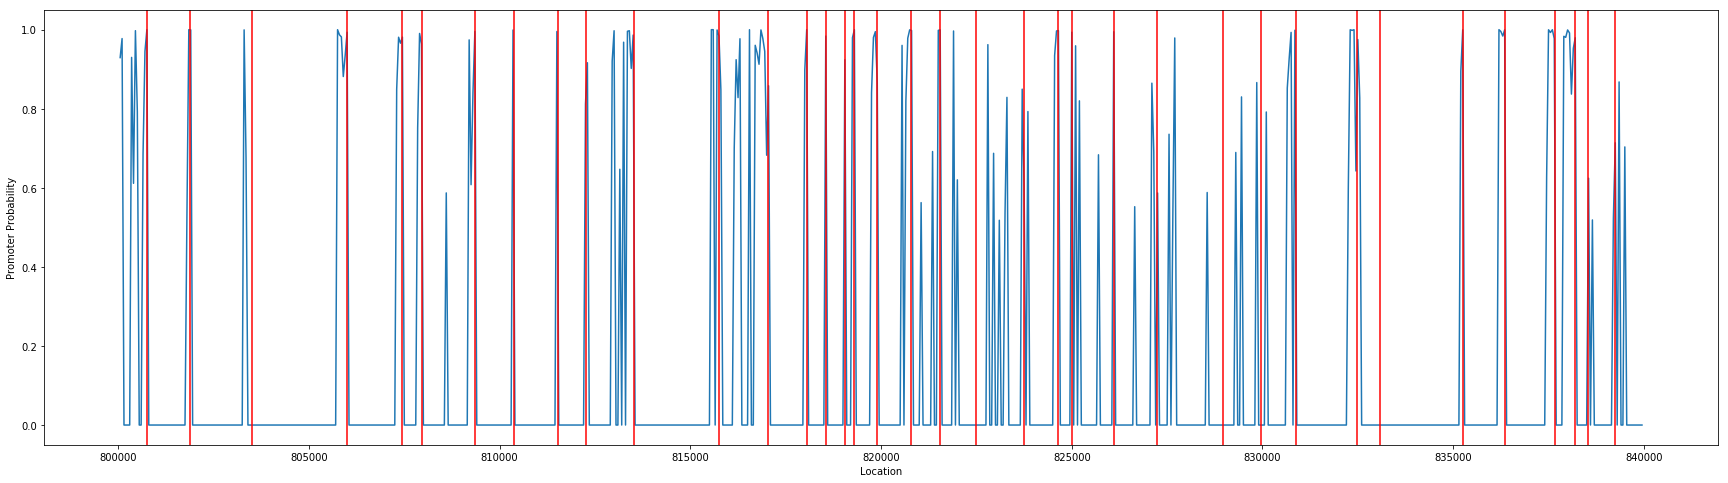

In [20]:
lim_low = 800000
lim_high = lim_low + 40000
plt.figure(figsize=(30,8))
palette = sns.color_palette("mako_r", 1)

df_subset = contig_df[(contig_df.Location < lim_high) & (contig_df.Location > lim_low)]

ax = sns.lineplot(x="Location", y="Promoter Probability", data=df_subset, palette=palette)
for tss in tss_locs:
    if tss > lim_low and tss < lim_high:
        plt.axvline(tss, color='r')
        
plt.savefig('prediction_plot.png')